## Multimodal Training Tabular Roots

Predict tabular roots classes (Durchwurzelung) from full images, after segmentation into horizon stripes

In [1]:
# Vipin
import os
os.chdir("/storage/projects/BGR Soil")
!pwd

/storage/projects/BGR Soil


In [2]:
import os
import pickle

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_  # modifies the tensors in-place (vs clip_grad_norm)
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from PIL import Image

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
import sys
sys.path.append('./BGR')
from bgr.soil.data.datasets import ImageTabularDataset
from bgr.soil.data.horizon_tabular_data import HorizonDataProcessor
import bgr.soil.modelling.general_models as bgr_mod
from bgr.soil.callbacks import EarlyStopping, ModelCheckpoint
from bgr.soil.transforms import VerticalStripeCrop
from bgr.soil.metrics import DepthMarkerLoss, TopKHorizonAccuracy
from bgr.soil.utils import pad_tensor

### Data Loading

In [4]:
dataprocessor = HorizonDataProcessor(label_embeddings_path='./BGR/label_embeddings/all_horizons_embeddings.pickle')
df = dataprocessor.load_processed_data()

train_df, val_df = dataprocessor.multi_label_stratified_shuffle_split(df)

/storage/projects/BGR Soil/./BGR/bgr/soil/data/horizon_tabular_data.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GrundwaStand'] = df['GrundwaStand'].str.replace('>', '').astype(float)
/storage/projects/BGR Soil/./BGR/bgr/soil/data/horizon_tabular_data.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ycoord'] = df['ycoord'].astype(float)
/storage/projects/BGR Soil/./BGR/bgr/soil/data/horizon_tabular_data.py:361: FutureWarning: Downcasting behavior in `replace` is deprecated and will be 

In [5]:
exploded_df = df.explode('Karbonat')
exploded_df = exploded_df.explode('Humusgehaltsklasse')  # Apply on the updated DataFrame
exploded_df = exploded_df.explode('Durchwurzelung')      # Apply on the updated DataFrame

# Used for constructing the tabular predictors in the general model
# For every tabular feature name, specify the output dimension and if it's a classification task
tabular_predictors_dict = {
    #'Soil_Type_Predictor':  {'output_dim': len(df['Bodenart'].unique()),           'classification': True},
    #'Soil_Color_Predictor': {'output_dim': len(df['Bodenfarbe'].unique()),         'classification': True},
    'Stones_Predictor':     {'output_dim': 1,                                      'classification': False},
    'Carbonate_Predictor':  {'output_dim': len(exploded_df['Karbonat'].unique()),           'classification': True},
    'Humus_Predictor':      {'output_dim': len(exploded_df['Humusgehaltsklasse'].unique()), 'classification': True},
    'Rooting_Predictor':    {'output_dim': len(exploded_df['Durchwurzelung'].unique()),     'classification': True}
}

tabular_predictors_dict

{'Stones_Predictor': {'output_dim': 1, 'classification': False},
 'Carbonate_Predictor': {'output_dim': 8, 'classification': True},
 'Humus_Predictor': {'output_dim': 8, 'classification': True},
 'Rooting_Predictor': {'output_dim': 7, 'classification': True}}

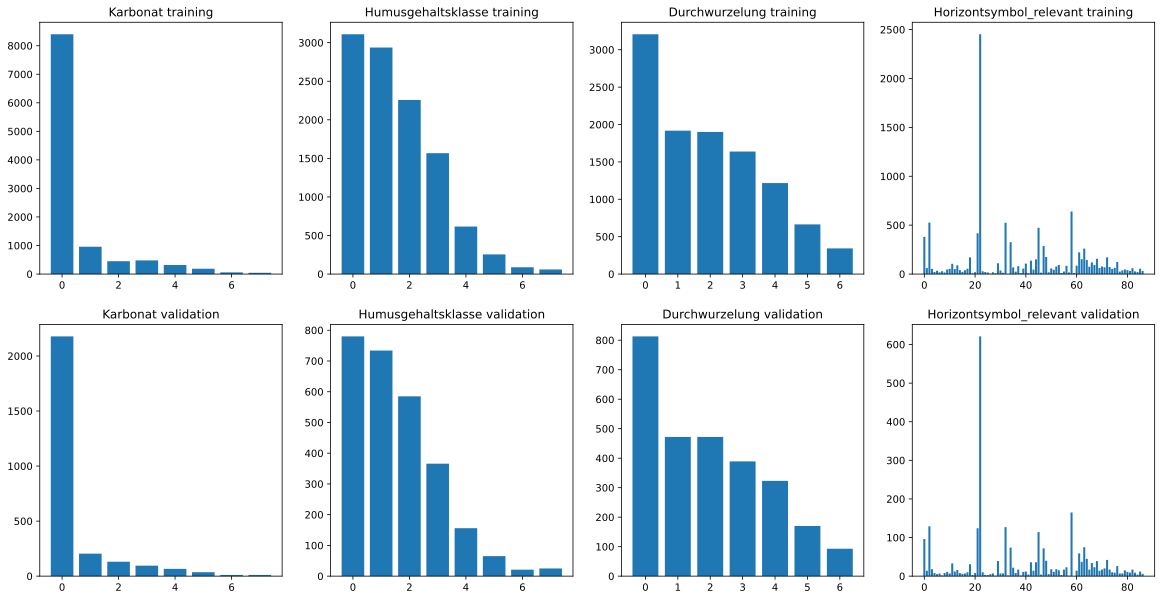

In [6]:
# If already computed, load the HCE embeddings for the labels (see Label_Graph.ipynb)
with open('./BGR/label_embeddings/all_horizons_embeddings.pickle', 'rb') as handle:
    emb_dict = pickle.load(handle)

plt.figure(figsize=(20, 10))
for i, (tab_feature, tab_predictor) in enumerate(zip(list(dataprocessor.stratified_split_targets), list(tabular_predictors_dict.keys())[1:] + ['Horizon_Predictor'])):
    if tab_predictor == 'Horizon_Predictor':
        num_cls = emb_dict['embedding'].shape[0]
    else:
        num_cls = tabular_predictors_dict[tab_predictor]['output_dim']
    for _ in range(num_cls):
        counts_train = train_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)
        counts_val   = val_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)

    plt.subplot(2, 4, i+1)
    plt.bar(list(range(num_cls)), list(counts_train.values))
    plt.title(tab_feature + ' training')
    plt.subplot(2, 4, i+5)
    plt.bar(list(range(num_cls)), list(counts_val.values))
    plt.title(tab_feature + ' validation')
plt.show()

### Training

In [7]:
# Get the lengths of the lists in the 'Untergrenze' column
list_lengths = df['Untergrenze'].apply(len)

min_length = list_lengths.min()
max_length = list_lengths.max()

print(f"Minimum number of horizons: {min_length}")
print(f"Maximum number of horizons: {max_length}")

Minimum number of horizons: 2
Maximum number of horizons: 8


In [8]:
min_length_list = df[df['Untergrenze'].apply(len) == min_length]['Untergrenze'].values[0]
max_length_list = df[df['Untergrenze'].apply(len) == max_length]['Untergrenze'].values[0]
print(f"List with minimum length: {min_length_list}")
print(f"List with maximum length: {max_length_list}")

List with minimum length: [0.32, 1.0]
List with maximum length: [0.13, 0.26, 0.4, 0.58, 0.68, 0.83, 0.98, 1.0]


In [9]:
# Define the image normalization
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet statistics
])

In [10]:
# Note: year and month should be handled differently
geotemp_categ = list(set(dataprocessor.categ_features).intersection(set(dataprocessor.geotemp_img_infos)))
# Get new number of geotemp columns
col_geotemp = [c for gt in dataprocessor.geotemp_img_infos for c in df.columns if c.startswith(gt)]

In [11]:
# Initialize model
#num_classes = len(df[target].unique()) # for one-hot encoding
#num_classes = emb_dict['embedding'].shape[1] # for HCE (the dim. of final layer in the model should match the dim of the embedded label vectors)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = bgr_mod.SegmentToTabular(tab_output_dim=tabular_predictors_dict['Rooting_Predictor']['output_dim'],
                                 classification=tabular_predictors_dict['Rooting_Predictor']['classification'],
                                 stop_token=1.0) # End of Sequence Token at -1 meters

model.to(device)

SegmentToTabular(
  (segment_encoder): HDCNNEncoder(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [12]:
# Data split
#train_df, val_df = train_test_split(df, stratify=df[target], random_state=2024)
#train_df, val_df = train_test_split(df, random_state=2024) # ToDo: not stratified...

print(f'{len(train_df)} samples for training.')
print(f'{len(val_df)} samples for validating.')

2677 samples for training.
670 samples for validating.


In [13]:
# Define the image transforms for augmentation
augment = [
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    #transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1., 3.))
    VerticalStripeCrop(stripe_width_range=(150, 200)),
    VerticalStripeCrop(stripe_width_range=(100, 150))
]

In [14]:
batch_size = 64
# Create Dataset object with image and tabular features
train_dataset = ImageTabularDataset(dataframe=train_df,
                                             image_size=(512, 512),
                                             normalize=normalize,
                                             augment=augment,
                                             image_path='file',
                                             label=None, # no label column as input; access it instead via 'index' during training
                                             feature_columns=col_geotemp[:-1]) # without 'file'

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16,
                          drop_last=True) # any better idea than drop_last? without it, tensors don't get concatenated properly

# Training parameters
lr, reg = 1e-3, 1e-3
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg)

depth_loss = DepthMarkerLoss(lambda_mono=0.0, lambda_div=0.0)
# All the tabular classifiers get a CE loss, all regressors get MSE
soil_losses = {}
for tab_predictor in tabular_predictors_dict:
    if tabular_predictors_dict[tab_predictor]['classification']:
        soil_losses[tab_predictor] = nn.CrossEntropyLoss()
    else:
        soil_losses[tab_predictor] = nn.MSELoss()

horizon_loss = nn.CosineEmbeddingLoss() # for HCE: 1 - cos(prediction, target)
horizon_acc = TopKHorizonAccuracy(torch.tensor(emb_dict['embedding'], device=device).float(), k=1)
hor_k = 5
horizon_topk_acc = TopKHorizonAccuracy(torch.tensor(emb_dict['embedding'], device=device).float(), k=hor_k)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


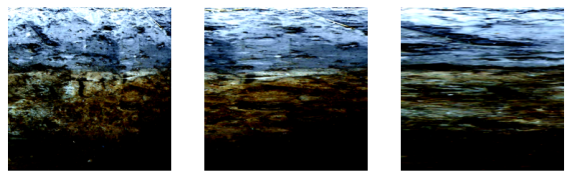

In [15]:
# Check an augmented subset
if augment:
    aug_images = []
    for i in range(len(train_dataset)):
        image, tabular_features = train_dataset[i]
        aug_images.append(image)
        #print(f"Image {i}")
        #print(tabular_features)
        if i == 2: break

    plt.figure(figsize=(10, 8))
    for i in range(len(aug_images)):
        plt.subplot(1, 3, i+1)
        plt.imshow(aug_images[i].swapaxes(0,2).swapaxes(0,1)) # returned shape is (c, h, w)
        plt.axis('off')

In [16]:
### Callbacks
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.1, min_lr=lr*0.01, verbose=True)
early_stopping = EarlyStopping(patience=10, min_delta=0.01, verbose=True) # looks at val_loss (see callbacks.py)
model_name = 'cnn_seg_mlp_tabular_root'
#model_name = 'cnn_seg_mlp_tabular_stones'
#model_name = 'cnn_seg_mlp_tabular_humus'
#model_name = 'cnn_seg_mlp_tabular_carb'
checkpoint = ModelCheckpoint(save_path='./BGR/models/' + model_name + '.pth', monitor='avg_val_loss', mode='min', verbose=True)

/storage/projects/BGR Soil/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
print(f"Training size original: {len(train_dataset.dataframe)}")
print(f"Training size after augmentation: {len(train_dataset)}")

Training size original: 2677
Training size after augmentation: 8031


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


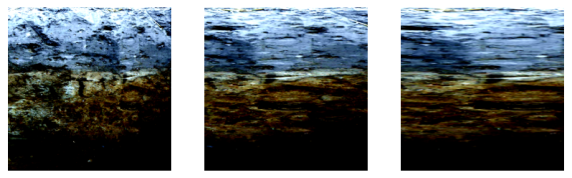

In [18]:
# Check an augmented subset
if augment:
    aug_images = []
    for i in range(len(train_dataset)):
        image, tabular_features = train_dataset[i]
        aug_images.append(image)
        #print(f"Image {i}")
        #print(tabular_features)
        if i == 2: break

    plt.figure(figsize=(10, 8))
    for i in range(len(aug_images)):
        plt.subplot(1, 3, i+1)
        plt.imshow(aug_images[i].swapaxes(0,2).swapaxes(0,1)) # returned shape is (c, h, w)
        plt.axis('off')

In [19]:
val_dataset = ImageTabularDataset(dataframe=val_df,
                                           image_size=(512, 512),
                                           normalize=normalize,
                                           image_path='file',
                                           label=None,
                                           feature_columns=col_geotemp[:-1]) # without 'file'

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=16, drop_last=True)

In [20]:
epochs = 20
lr_history, train_loss_history, val_loss_history = [], [], []
train_carb_acc_history, train_humus_acc_history, train_root_acc_history = [], [], []
val_carb_acc_history, val_humus_acc_history, val_root_acc_history = [], [], []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Training loop
    model.train() # Important: reset the model in training mode at the beginning of every epoch
    train_loss_total = 0.0
    train_carb_correct, train_humus_correct, train_root_correct = 0, 0, 0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch in train_loader_tqdm:
        _, geotemp_features = batch
        geotemp_features = geotemp_features.to(device)

        optimizer.zero_grad() # otherwise, PyTorch accumulates the gradients during backprop

        # Get corresponding true depth markers and morphological features via index column in df (the first value in every row in geotemp)
        # Note: the code accounts for duplicate indexes resulting after the augmentations in the ImageTabularDataset class (is there a better way than duplicating indexes during augmentation?)
        true_stones, true_carb, true_humus, true_root = [], [], [], []
        cropped_images = []
        batch_indices = geotemp_features.cpu().numpy()[:, 0]
        for idx in batch_indices:
            true_depths = df.loc[df['index'] == idx, 'Untergrenze'].values[0]
            #true_stones.append( torch.tensor(df.loc[df['index'] == idx, 'Steine'].values[0]) )
            #true_carb.append( torch.tensor(df.loc[df['index'] == idx, 'Karbonat'].values[0]) )
            #true_humus.append( torch.tensor(df.loc[df['index'] == idx, 'Humusgehaltsklasse'].values[0]) )
            true_root.append( torch.tensor(df.loc[df['index'] == idx, 'Durchwurzelung'].values[0]) )

            ### Crop images before resizing as input into segment encoder
            # Note: won't work for duplicate indexes of the augmented images...
            img_file = df.loc[df['index'] == idx, 'file'].values[0]
            img = transforms.ToTensor()(Image.open(img_file))
            C, H, W = img.size()
            # Stop at the first occurrence of stop_token (inclusive)
            if model.stop_token in true_depths:
                true_depths = true_depths[:true_depths.index(model.stop_token) + 1]
            # Convert normalized depth markers to pixel indices
            pixel_depths = [int(d * H) for d in [0.0] + true_depths]  # Add 0.0 for upmost bound
            for j in range(len(pixel_depths) - 1):
                upper, lower = pixel_depths[j], pixel_depths[j + 1]
                cropped = img[:, upper:lower, :]  # Crop along the height axis
                cropped_resized = F.interpolate(cropped.unsqueeze(0), size=train_dataset.image_size, mode='bilinear', align_corners=False)
                cropped_images.append(cropped_resized.squeeze())
        cropped_images = torch.stack(cropped_images).to(device)

        #true_stones  = torch.stack([item for sublist in true_stones for item in sublist], dim=0).to(device)
        #true_carb    = torch.stack([item for sublist in true_carb for item in sublist], dim=0).to(device)
        #true_humus   = torch.stack([item for sublist in true_humus for item in sublist], dim=0).to(device)
        true_root    = torch.stack([item for sublist in true_root for item in sublist], dim=0).to(device)

        # Predict morphological features (only pred_stones is a number from regression, the rest are softmax)
        tabular_predictions = model(cropped_images=cropped_images) #geo_temp=geotemp_features[:, 1:] # 'index' column not used in model

        # Compute individual losses
        #train_loss = soil_losses['Stones_Predictor'](tabular_predictions, true_stones)
        #train_loss = soil_losses['Carbonate_Predictor'](tabular_predictions, true_carb)
        #train_loss = soil_losses['Humus_Predictor'](tabular_predictions, true_humus)
        train_loss = soil_losses['Rooting_Predictor'](tabular_predictions, true_root)

        train_loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Calculate batch losses to total loss
        train_loss_total += train_loss.item()

        # Calculate accuracies for categorical tabular features
        #train_carb_correct += (torch.argmax(tabular_predictions, 1) == true_carb).float().mean().item()
        #train_humus_correct += (torch.argmax(tabular_predictions, 1) == true_humus).float().mean().item()
        train_root_correct += (torch.argmax(tabular_predictions, 1) == true_root).float().mean().item()

        train_loader_tqdm.set_postfix(loss=train_loss.item())

    # Average losses and accuracies at the end of the epoch
    avg_train_loss = train_loss_total / len(train_loader) # divide by number of batches

    #train_carb_acc = train_carb_correct / len(train_loader)
    #train_humus_acc = train_humus_correct / len(train_loader)
    train_root_acc = train_root_correct / len(train_loader)
    # Note: because of shuffle and drop_last, the training set has a slightly different number of horizons in every epoch (same applies for val_set).
    # The difference is, however, negligible (~10 horizons out of 30k in training).

    # Evaluation loop
    model.eval() # Set model in evaluation mode before running inference
    val_loss_total = 0.0
    val_carb_correct, val_humus_correct, val_root_correct = 0, 0, 0
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in val_loader_tqdm:
            _, geotemp_features = batch
            geotemp_features = geotemp_features.to(device)

            # Get corresponding true depth markers via index column in df (see training step above)
            true_stones, true_carb, true_humus, true_root = [], [], [], []
            cropped_images = []
            batch_indices = geotemp_features.cpu().numpy()[:, 0]
            for idx in batch_indices:
                true_depths = df.loc[df['index'] == idx, 'Untergrenze'].values[0]
                #true_stones.append( torch.tensor(df.loc[df['index'] == idx, 'Steine'].values[0]) )
                #true_carb.append( torch.tensor(df.loc[df['index'] == idx, 'Karbonat'].values[0]) )
                #true_humus.append( torch.tensor(df.loc[df['index'] == idx, 'Humusgehaltsklasse'].values[0]) )
                true_root.append( torch.tensor(df.loc[df['index'] == idx, 'Durchwurzelung'].values[0]) )

                ### Crop images before resizing as input into segment encoder
                # Note: won't work for duplicate indexes of the augmented images...
                img_file = df.loc[df['index'] == idx, 'file'].values[0]
                img = transforms.ToTensor()(Image.open(img_file))
                C, H, W = img.size()
                # Stop at the first occurrence of stop_token (inclusive)
                if model.stop_token in true_depths:
                    true_depths = true_depths[:true_depths.index(model.stop_token) + 1]
                # Convert normalized depth markers to pixel indices
                pixel_depths = [int(d * H) for d in [0.0] + true_depths]  # Add 0.0 for upmost bound
                for j in range(len(pixel_depths) - 1):
                    upper, lower = pixel_depths[j], pixel_depths[j + 1]
                    cropped = img[:, upper:lower, :]  # Crop along the height axis
                    cropped_resized = F.interpolate(cropped.unsqueeze(0), size=train_dataset.image_size, mode='bilinear', align_corners=False)
                    cropped_images.append(cropped_resized.squeeze())
            cropped_images = torch.stack(cropped_images).to(device)

            #true_stones  = torch.stack([item for sublist in true_stones for item in sublist], dim=0).to(device)
            #true_carb    = torch.stack([item for sublist in true_carb for item in sublist], dim=0).to(device)
            #true_humus   = torch.stack([item for sublist in true_humus for item in sublist], dim=0).to(device)
            true_root    = torch.stack([item for sublist in true_root for item in sublist], dim=0).to(device)

            # Predict depth markers (as padded tensors) and morphological features
            tabular_predictions = model(cropped_images=cropped_images) #geo_temp=geotemp_features[:, 1:]

            # Compute batch losses
            #val_loss = soil_losses['Stones_Predictor'](tabular_predictions, true_stones)
            #val_loss = soil_losses['Carbonate_Predictor'](tabular_predictions, true_carb)
            #val_loss  = soil_losses['Humus_Predictor'](tabular_predictions, true_humus)
            val_loss = soil_losses['Rooting_Predictor'](tabular_predictions, true_root)

            # Add batch losses to total loss
            val_loss_total += val_loss.item()

            # Calculate accuracies for categorical tabular features
            #val_carb_correct += (torch.argmax(tabular_predictions, 1) == true_carb).float().mean().item()
            #val_humus_correct += (torch.argmax(tabular_predictions, 1) == true_humus).float().mean().item()
            val_root_correct += (torch.argmax(tabular_predictions, 1) == true_root).float().mean().item()

    # Average losses and accuracies at the end of the epoch
    avg_val_loss = val_loss_total / len(val_loader) # divide by number of batches

    #val_carb_acc = val_carb_correct / len(val_loader)
    #val_humus_acc = val_humus_correct / len(val_loader)
    val_root_acc = val_root_correct / len(val_loader)

    # Save checkpoint if validation loss is at an optimum
    checkpoint(model, avg_val_loss)
    # Apply the scheduler with validation loss
    scheduler.step(avg_val_loss)
    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)

    # Log metrics
    train_loss_history.append(avg_train_loss); val_loss_history.append(avg_val_loss)

    #train_carb_acc_history.append(train_carb_acc); val_carb_acc_history.append(val_carb_acc)
    #train_humus_acc_history.append(train_humus_acc); val_humus_acc_history.append(val_humus_acc)
    train_root_acc_history.append(train_root_acc); val_root_acc_history.append(val_root_acc)

    print(f"Epoch {epoch+1}, Training:")
    #print(f"Stones Loss: {avg_train_loss:.4f}")
    #print(f"Carb Loss: {avg_train_loss:.4f}, Carb Accuracy: {train_carb_acc:.4f}")
    #print(f"Humus Loss: {avg_train_loss:.4f}, Humus Accuracy: {train_humus_acc:.4f}")
    print(f"Root Loss: {avg_train_loss:.4f}, Root Accuracy: {train_root_acc:.4f}")
    print(f"\nValidation:")
    #print(f"Stones Loss: {avg_val_loss:.4f}")
    #print(f"Carb Loss: {avg_val_loss:.4f}, Carb Accuracy: {val_carb_acc:.4f}")
    #print(f"Humus Loss: {avg_val_loss:.4f}, Humus Accuracy: {val_humus_acc:.4f}")
    print(f"Root Loss: {avg_val_loss:.4f}, Root Accuracy: {val_root_acc:.4f}")
    print(f"Current LR: {current_lr}")

    # Early stopping check
    early_stopping(avg_val_loss)
    if early_stopping.should_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/20


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Model checkpoint saved at './BGR/models/cnn_seg_mlp_tabular_root.pth' with avg_val_loss: 1.7503
Epoch 1, Training:
Root Loss: 1.7632, Root Accuracy: 0.2890

Validation:
Root Loss: 1.7503, Root Accuracy: 0.2712
Current LR: 0.001
Epoch 2/20


KeyboardInterrupt: 

### Evaluation

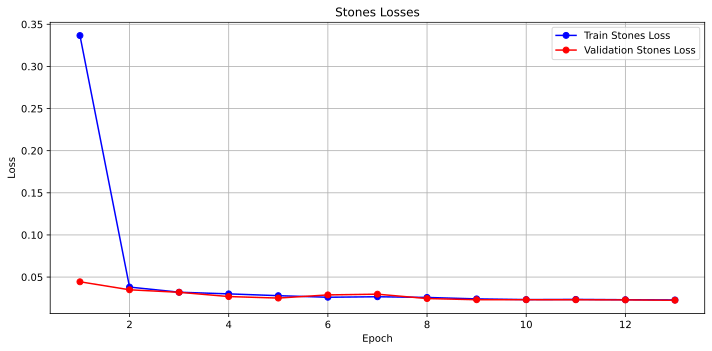

In [ ]:
complete_epochs = len(train_loss_history) + 1
loss_histories = {
    'Stones': (train_loss_history, val_loss_history)
}

plt.figure(figsize=(10, 5))
for i, (title, (train_history, val_history)) in enumerate(loss_histories.items()):
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title} Loss', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title} Loss', marker='o', color='r')
    plt.title(f'{title} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

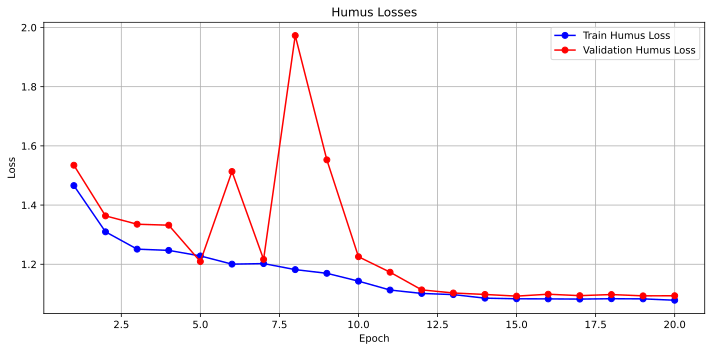

In [ ]:
complete_epochs = len(train_loss_history) + 1
loss_histories = {
    'Humus': (train_loss_history, val_loss_history)
}

plt.figure(figsize=(10, 5))
for i, (title, (train_history, val_history)) in enumerate(loss_histories.items()):
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title} Loss', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title} Loss', marker='o', color='r')
    plt.title(f'{title} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

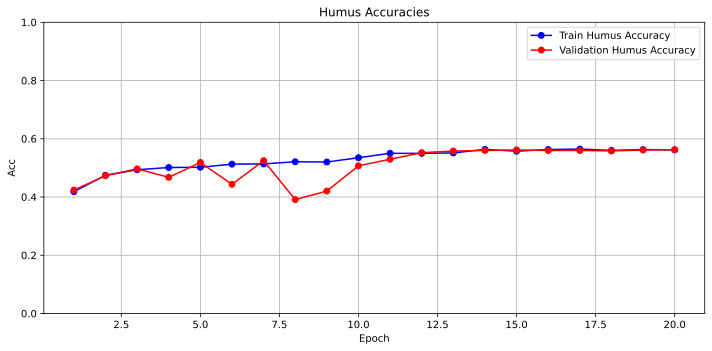

In [ ]:
acc_histories = {
    'Humus': (train_humus_acc_history, val_humus_acc_history)
}

plt.figure(figsize=(10, 5))
for i, (title, (train_history, val_history)) in enumerate(acc_histories.items()):
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title} Accuracy', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title} Accuracy', marker='o', color='r')
    plt.title(f'{title} Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.ylim([0.0, 1.0])
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

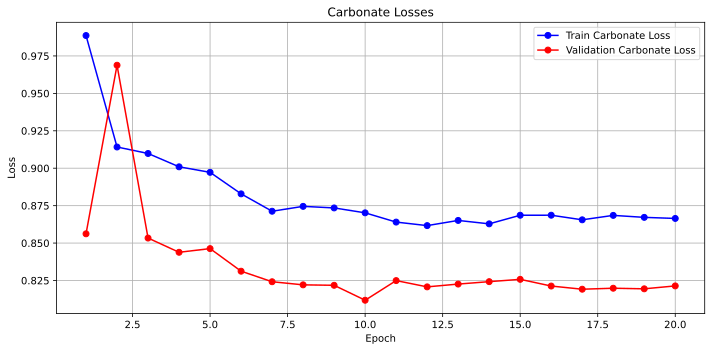

In [ ]:
complete_epochs = len(train_loss_history) + 1
loss_histories = {
    'Carbonate': (train_loss_history, val_loss_history)
}

plt.figure(figsize=(10, 5))
for i, (title, (train_history, val_history)) in enumerate(loss_histories.items()):
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title} Loss', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title} Loss', marker='o', color='r')
    plt.title(f'{title} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

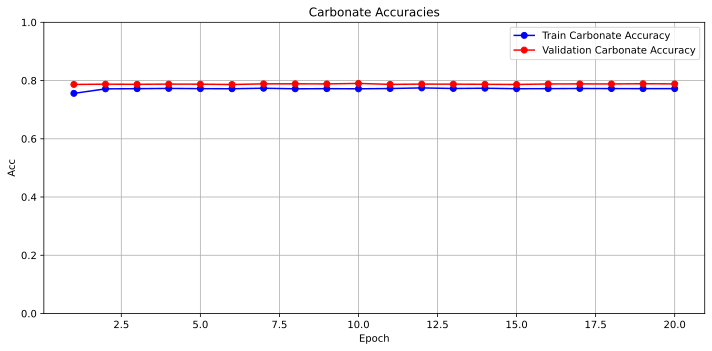

In [ ]:
acc_histories = {
    'Carbonate': (train_carb_acc_history, val_carb_acc_history)
}

plt.figure(figsize=(10, 5))
for i, (title, (train_history, val_history)) in enumerate(acc_histories.items()):
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title} Accuracy', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title} Accuracy', marker='o', color='r')
    plt.title(f'{title} Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.ylim([0.0, 1.0])
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Note: the carbonate predictor basically only predicts the dominant class
np.argmax(tabular_predictions.cpu(), axis=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
true_carb

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 5, 3, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 4,
        4, 3, 1, 0, 0, 0, 0, 0, 0, 1, 1, 6, 7, 0, 0, 0, 0, 3, 5, 5, 5, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 2, 2, 2, 4, 3, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
        4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3,
        5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

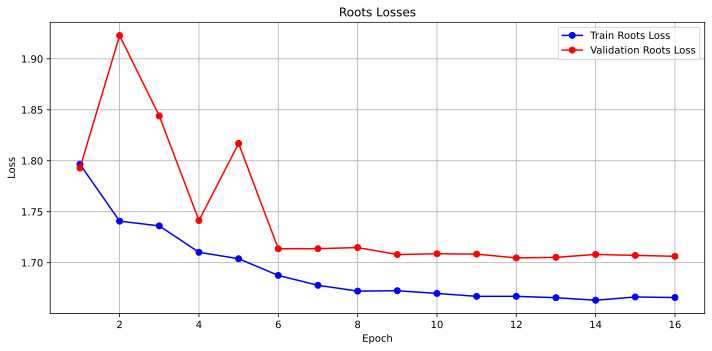

In [ ]:
complete_epochs = len(train_loss_history) + 1
loss_histories = {
    'Roots': (train_loss_history, val_loss_history)
}

plt.figure(figsize=(10, 5))
for i, (title, (train_history, val_history)) in enumerate(loss_histories.items()):
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title} Loss', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title} Loss', marker='o', color='r')
    plt.title(f'{title} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

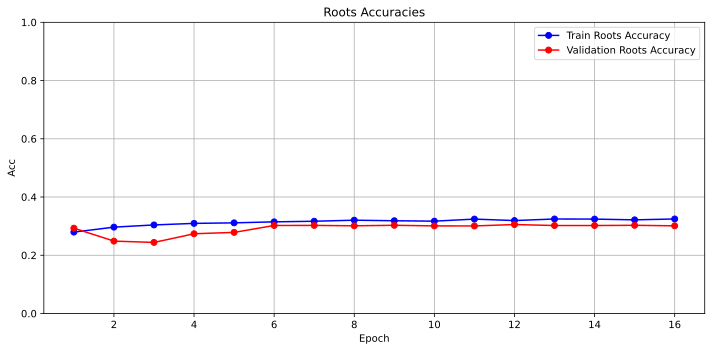

In [ ]:
acc_histories = {
    'Roots': (train_root_acc_history, val_root_acc_history)
}

plt.figure(figsize=(10, 5))
for i, (title, (train_history, val_history)) in enumerate(acc_histories.items()):
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title} Accuracy', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title} Accuracy', marker='o', color='r')
    plt.title(f'{title} Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.ylim([0.0, 1.0])
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
history_data = {
    'train_loss': train_loss_history,
    'val_loss': val_loss_history,
    #'train_carb_acc': train_carb_acc_history,
    #'val_carb_acc': val_carb_acc_history,
    #'train_humus_acc': train_humus_acc_history,
    #'val_humus_acc': val_humus_acc_history,
    'train_root_acc': train_root_acc_history,
    'val_root_acc': val_root_acc_history,
    #'train_horizon_acc': train_horizon_acc_history,
    #'val_horizon_acc': val_horizon_acc_history,
    #'train_horizon_topk_acc': train_horizon_topk_acc_history,
    #'val_horizon_topk_acc': val_horizon_topk_acc_history,
}

# Save the dictionary to a pickle file
with open('./BGR/figures/histories/' + model_name + '.pickle', 'wb') as f:
    pickle.dump(history_data, f)

In [ ]:
# Load history dictionary
with open('./BGR/figures/histories/' + model_name + '.pickle', 'rb') as handle:
    history_data = pickle.load(handle)

In [ ]:
acc_histories = {
    'Carbonate': (train_carb_acc_history, val_carb_acc_history),
    'Humus': (train_humus_acc_history, val_humus_acc_history),
    'Rooting': (train_root_acc_history, val_root_acc_history)
}

plt.figure(figsize=(10, 5))
for i, (title, (train_history, val_history)) in enumerate(acc_histories.items()):
    plt.plot(range(1, complete_epochs), train_history, label=f'Train {title} Accuracy', marker='o', color='b')
    plt.plot(range(1, complete_epochs), val_history, label=f'Validation {title} Accuracy', marker='o', color='r')
    plt.title(f'{title} Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.ylim([0.0, 1.0])
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()